**This is a Baseline Model:** In this notebook, we run baseline model and recode the accuracy.


In [25]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"aminehfar","key":"2d4f6af9b6786be61ec95dd320c3d7d2"}'}

In [26]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [27]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content
!unzip -q /content/brain-tumor-mri-dataset.zip -d /content/brain_tumor

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/brain_tumor/Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [28]:
import os
print(os.listdir("/content/brain_tumor"))


['Testing', 'Training']


In [29]:
data_dir = "/content/brain_tumor"
print(os.listdir(data_dir))        # ['Training', 'Testing']
print(os.listdir(f"{data_dir}/Training"))  # ['glioma', 'meningioma', 'notumor', 'pituitary']


['Testing', 'Training']
['meningioma', 'glioma', 'pituitary', 'notumor']


In [30]:
import os, time, torch, numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [31]:
# ---- Config ----
DATA_DIR = "/kaggle/input/brain-tumor-mri-dataset"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 5
LR = 1e-3
NUM_WORKERS = 2

In [32]:
# ====== device ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [33]:
# ====== transforms ======
IMG_SIZE = 224
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])
val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

In [34]:
# ====== datasets & loaders ======
data_dir = "/content/brain_tumor"   # path
train_ds = datasets.ImageFolder(os.path.join(data_dir, "Training"), transform=train_tfms)
val_ds   = datasets.ImageFolder(os.path.join(data_dir, "Testing"),   transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

class_names = train_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [35]:
# ====== simple CNN ======
class SimpleBrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 224 -> 112
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 112 -> 56
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 56 -> 28
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28, 256), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SimpleBrainTumorCNN(num_classes=num_classes).to(device)


In [36]:
# ====== loss & optimizer ======
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [37]:
# ====== training loop ======
def train(model, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)
            train_correct += (out.argmax(1) == y).sum().item()

        # validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item() * x.size(0)
                val_correct += (out.argmax(1) == y).sum().item()

        print(f"Epoch {epoch+1}: "
              f"Train loss {train_loss/len(train_ds):.4f}, acc {train_correct/len(train_ds):.3f} | "
              f"Val loss {val_loss/len(val_ds):.4f}, acc {val_correct/len(val_ds):.3f}")

train(model, train_loader, val_loader, epochs=5)


Epoch 1: Train loss 0.6823, acc 0.741 | Val loss 0.5246, acc 0.766
Epoch 2: Train loss 0.3822, acc 0.852 | Val loss 0.3785, acc 0.846
Epoch 3: Train loss 0.2643, acc 0.899 | Val loss 0.2732, acc 0.892
Epoch 4: Train loss 0.1915, acc 0.935 | Val loss 0.2185, acc 0.917
Epoch 5: Train loss 0.1545, acc 0.943 | Val loss 0.1473, acc 0.950


In [38]:
# ===========================
# 7. Test accuracy
# ===========================
def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    print(f"Test Accuracy: {correct/total:.4f}")

evaluate(model, val_loader)


Test Accuracy: 0.9504


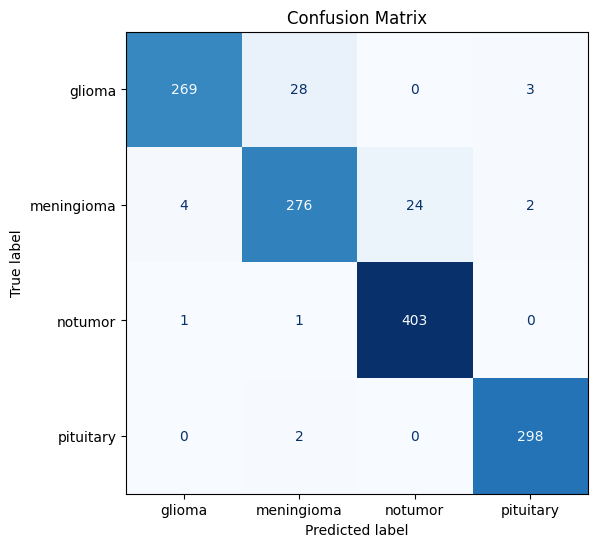

In [40]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, loader, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
    plt.title("Confusion Matrix")
    plt.show()

# Usage (after training, use validation or test loader)
plot_confusion_matrix(model, val_loader, train_ds.classes)
